In [59]:
# Import Dependencies

import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.mogit del_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

In [60]:
# Define Functions

def evaluate_model(test, pred, model_name):
    
    # Calculate accuracy score
    accuracy = accuracy_score(test, pred)
    print(f"{model_name} Accuracy: {round(accuracy*100,2)}%\n\n")

    # Generate a confusion matrix
    conf_matrix = confusion_matrix(test, pred)
    print(f"{model_name} Confusion Matrix:\n\n{conf_matrix}\n\n")

    # Generate a classification report
    classification = classification_report(test, pred, output_dict=True)
    recall = classification['macro avg']['recall']
    f1 = classification['macro avg']['f1-score']
    prec = classification['macro avg']['precision']


    print(f"{model_name} Classification Report:\n\n{classification_report(test, pred)}\n\n")

    # Plot the confusion matrix as a heatmap
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    return prec, accuracy, recall, f1


## Data Preparation (Cleaning and Pre-Processing)

In [61]:
# Read in the CSV file
breast_cancer_data = pd.read_csv('Resource/cancer_data.csv', usecols=lambda col: col != 'Unnamed: 32')

# Display the first few rows of the DataFrame
breast_cancer_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [62]:
# Drop the non-beneficial ID columns, 'id'
breast_cancer_data = breast_cancer_data.drop(columns = ['id'])

# Print the data types of each column
breast_cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [63]:
# Determine the number of unique values in each column.
unique_value_counts = breast_cancer_data.nunique()
print(unique_value_counts)

diagnosis                    2
radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave points_mean        542
symmetry_mean              432
fractal_dimension_mean     499
radius_se                  540
texture_se                 519
perimeter_se               533
area_se                    528
smoothness_se              547
compactness_se             541
concavity_se               533
concave points_se          507
symmetry_se                498
fractal_dimension_se       545
radius_worst               457
texture_worst              511
perimeter_worst            514
area_worst                 544
smoothness_worst           411
compactness_worst          529
concavity_worst            539
concave points_worst       492
symmetry_worst             500
fractal_dimension_worst    535
dtype: int64


In [64]:
# Check the Target Class frequency
breast_cancer_data['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [65]:
# Drop the 'id' column and set the diagnosis column as the target variable
X = breast_cancer_data.drop(columns=['diagnosis'])
y = breast_cancer_data['diagnosis'].map({'M': 1, 'B': 0})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Logistic Regression using original data 

In [66]:
# Create a Logistic Regression model with a higher maximum number of iterations
logreg = LogisticRegression(max_iter=5000)

# Fit the model to the breast cancer data
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=5000)

Logistic Regression Accuracy: 95.61%


Logistic Regression Confusion Matrix:

[[70  1]
 [ 4 39]]


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        71
           1       0.97      0.91      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114





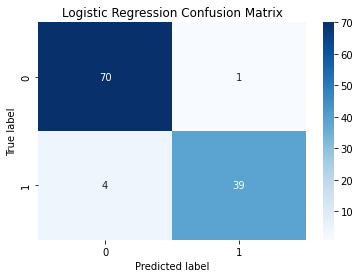

In [67]:
# Predict on test set and calculate accuracy
y_pred_log = logreg.predict(X_test)

# Evaluate the Model
linreg_prec, linreg_accuracy, linreg_recall, linreg_f1 = evaluate_model(y_test, y_pred_log, "Logistic Regression")


True Negatives: 70
    
False Positives: 1
    
False Negatives: 4
    
True Positives: 39

## Logistic Regression Model with Resampled Training Data

### Step 1: Use the RandomOverSampler module from the imbalanced-learn library to resample the data. Be sure to confirm that the labels have an equal number of data points.


In [116]:
# Import the RandomOverSampler module form imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [117]:
# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
random_oversampler_model = RandomOverSampler(random_state = 1)

In [118]:
# Fit the original training data to the random_oversampler model
X_rsample, y_rsample = random_oversampler_model.fit_resample(X_train, y_train)
# Count the distinct values of the resampled labels data
y_rsample.value_counts()

diagnosis
0    286
1    286
Name: count, dtype: int64

### Step 2: Use the LogisticRegression classifier and the resampled data to fit the model and make predictions.

In [106]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
sample_classifier = LogisticRegression(solver='lbfgs', random_state=1)

# Fit the model using training data
sample_classifier.fit(X_rsample, y_rsample)

# Make a prediction using the testing data
y_pred_log_balance = sample_classifier.predict(X_test)
pd.DataFrame({"Prediction": y_pred_log_balance, "Actual": y_test}).head()

,Prediction,Actual
204,0,0
70,1,1
131,1,1
431,0,0
540,0,0


### Step 3: Evaluate the model’s performance by doing the following:

* Calculate the accuracy score of the model.

* Generate a confusion matrix.

* Print the classification report.

Logistic Regression Accuracy: 98.25%


Logistic Regression Confusion Matrix:

[[70  1]
 [ 1 42]]


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114





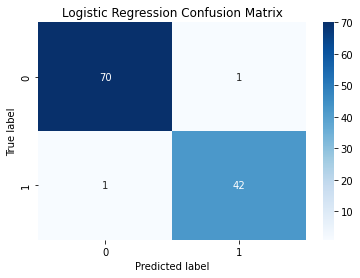

In [107]:
# Predict on test set and calculate accuracy
y_pred_log_balance = sample_classifier.predict(X_test)

# Evaluate the Model
linreg_prec_balance, linreg_accuracy_balance, linreg_recall_balance, linreg_f1_balance = evaluate_model(y_test, y_pred_log_balance, "Logistic Regression")

## Support Vector Machine (SVM) using the 'linear' basis function kernel ("rbf")

In [121]:
# Initialize and fit SVM model
svmL = SVC(kernel='linear')
svmL.fit(X_train, y_train)

SVC(kernel='linear')

SVM Accuracy: 95.61%


SVM Confusion Matrix:

[[68  3]
 [ 2 41]]


SVM Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114





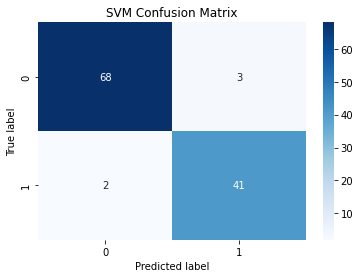

In [122]:
# Predict on test set and calculate accuracy
y_pred_svmL = svm.predict(X_test)

# Evaluate the model
svm_precL, svm_accuracyL, svm_recallL, svm_f1L = evaluate_model(y_test, y_pred_svmL, "SVM")


## Support Vector Machine (SVM) using the radial basis function kernel ("rbf")

In [123]:
# Initialize and fit SVM model
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)


SVC()

SVM Accuracy: 98.25%


SVM Confusion Matrix:

[[71  0]
 [ 2 41]]


SVM Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114





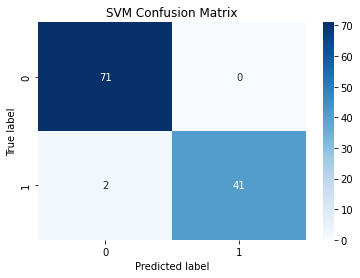

In [124]:
# Predict on test set and calculate accuracy
y_pred_svm = svm.predict(X_test)

# Evaluate the model
svm_prec, svm_accuracy, svm_recall, svm_f1 = evaluate_model(y_test, y_pred_svm, "SVM")


## Neural Networks

In [125]:
# Define the model
model = Sequential()
model.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, nn_accuracy = model.evaluate(X_test, y_test)
print(f'\n\nTest loss: {loss:.4f}\nTest accuracy: {nn_accuracy*100:.2f}%\n\n')

Epoch 1/10
29/29 [==============================] - 2s 14ms/step - loss: 0.6361 - accuracy: 0.5560 - val_loss: 0.6092 - val_accuracy: 0.7193
Epoch 2/10
29/29 [==============================] - 0s 5ms/step - loss: 0.5883 - accuracy: 0.8352 - val_loss: 0.5705 - val_accuracy: 0.8684
Epoch 3/10
29/29 [==============================] - 0s 6ms/step - loss: 0.5527 - accuracy: 0.8989 - val_loss: 0.5384 - val_accuracy: 0.9035
Epoch 4/10
29/29 [==============================] - 0s 5ms/step - loss: 0.5231 - accuracy: 0.9165 - val_loss: 0.5109 - val_accuracy: 0.9211
Epoch 5/10
29/29 [==============================] - 0s 5ms/step - loss: 0.4979 - accuracy: 0.9297 - val_loss: 0.4883 - val_accuracy: 0.9386
Epoch 6/10
29/29 [==============================] - 0s 5ms/step - loss: 0.4768 - accuracy: 0.9363 - val_loss: 0.4696 - val_accuracy: 0.9474
Epoch 7/10
29/29 [==============================] - 0s 6ms/step - loss: 0.4594 - accuracy: 0.9473 - val_loss: 0.4527 - val_accuracy: 0.9474
Epoch 8/10
29/29 [=

4/4 [==============================] - 0s 3ms/step
Neural Network Accuracy: 96.49%


Neural Network Confusion Matrix:

[[68  3]
 [ 1 42]]


Neural Network Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        71
           1       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114





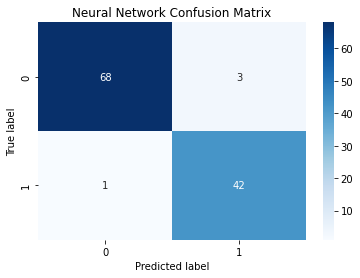

In [90]:
# Predict on test set and calculate accuracy
y_pred_proba = model.predict(X_test)
y_pred_nn = np.round(y_pred_proba).astype(int)


# Evaluate the Model

nn_prec, nn_accuracy, nn_recall, nn_f1 = evaluate_model(y_test, y_pred_nn, "Neural Network")


True Negatives: 53

False Positives: 18

False Negatives: 4

True Positives: 39

## Optimized Neural Network 1.1

In [91]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, opt_nn_accuracy = model.evaluate(X_test, y_test)
print(f'\n\nTest loss: {loss:.4f}\nTest accuracy: {opt_nn_accuracy*100:.2f}%\n\n')

Epoch 1/50
29/29 [==============================] - 3s 15ms/step - loss: 0.6252 - accuracy: 0.8132 - val_loss: 0.5663 - val_accuracy: 0.9123
Epoch 2/50
29/29 [==============================] - 0s 6ms/step - loss: 0.4816 - accuracy: 0.9231 - val_loss: 0.4016 - val_accuracy: 0.9386
Epoch 3/50
29/29 [==============================] - 0s 6ms/step - loss: 0.3368 - accuracy: 0.9275 - val_loss: 0.2652 - val_accuracy: 0.9649
Epoch 4/50
29/29 [==============================] - 0s 7ms/step - loss: 0.2324 - accuracy: 0.9495 - val_loss: 0.1801 - val_accuracy: 0.9649
Epoch 5/50
29/29 [==============================] - 0s 6ms/step - loss: 0.1694 - accuracy: 0.9538 - val_loss: 0.1338 - val_accuracy: 0.9649
Epoch 6/50
29/29 [==============================] - 0s 6ms/step - loss: 0.1347 - accuracy: 0.9626 - val_loss: 0.1081 - val_accuracy: 0.9649
Epoch 7/50
29/29 [==============================] - 0s 6ms/step - loss: 0.1135 - accuracy: 0.9736 - val_loss: 0.0937 - val_accuracy: 0.9649
Epoch 8/50
29/29 [=

4/4 [==============================] - 0s 3ms/step
Optimized Neural Network Accuracy: 98.25%


Optimized Neural Network Confusion Matrix:

[[70  1]
 [ 1 42]]


Optimized Neural Network Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114





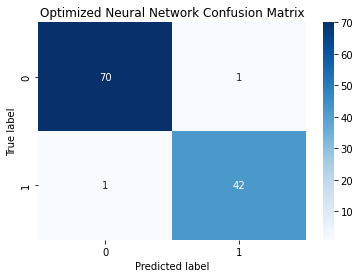

In [78]:
# Predict on test set and calculate accuracy
y_pred_proba = model.predict(X_test)
y_pred_opt_nn = np.round(y_pred_proba).astype(int)

# Evaluate the Model
opt_nn_prec, opt_nn_accuracy, opt_nn_recall, opt_nn_f1 = evaluate_model(y_test, y_pred_opt_nn, "Optimized Neural Network")

In [101]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, opt2_nn_accuracy = model.evaluate(X_test, y_test)
print(f'\n\nTest loss: {loss:.4f}\nTest accuracy: {opt2_nn_accuracy*100:.2f}%\n\n')

Epoch 1/50
29/29 [==============================] - 2s 17ms/step - loss: 0.8532 - accuracy: 0.3714 - val_loss: 0.8036 - val_accuracy: 0.3772
Epoch 2/50
29/29 [==============================] - 0s 6ms/step - loss: 0.7726 - accuracy: 0.3714 - val_loss: 0.7348 - val_accuracy: 0.3772
Epoch 3/50
29/29 [==============================] - 0s 5ms/step - loss: 0.7143 - accuracy: 0.3714 - val_loss: 0.6875 - val_accuracy: 0.3772
Epoch 4/50
29/29 [==============================] - 0s 5ms/step - loss: 0.6728 - accuracy: 0.5385 - val_loss: 0.6546 - val_accuracy: 0.9386
Epoch 5/50
29/29 [==============================] - 0s 5ms/step - loss: 0.6439 - accuracy: 0.9143 - val_loss: 0.6282 - val_accuracy: 0.9211
Epoch 6/50
29/29 [==============================] - 0s 6ms/step - loss: 0.6197 - accuracy: 0.9011 - val_loss: 0.6056 - val_accuracy: 0.8860
Epoch 7/50
29/29 [==============================] - 0s 6ms/step - loss: 0.5975 - accuracy: 0.8791 - val_loss: 0.5824 - val_accuracy: 0.8860
Epoch 8/50
29/29 [=

4/4 [==============================] - 0s 3ms/step
Optimized Neural Network Accuracy: 99.12%


Optimized Neural Network Confusion Matrix:

[[71  0]
 [ 1 42]]


Optimized Neural Network Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        71
           1       1.00      0.98      0.99        43

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114





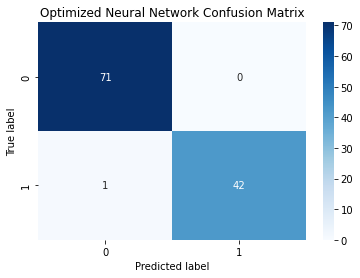

In [102]:
# Predict on test set and calculate accuracy
y_pred_proba = model.predict(X_test)
y_pred_opt2_nn = np.round(y_pred_proba).astype(int)

# Evaluate the Model
opt2_nn_prec, opt2_nn_accuracy, opt2_nn_recall, opt2_nn_f1 = evaluate_model(y_test, y_pred_opt2_nn, "Optimized Neural Network")

## Score Comparison 

In [129]:
# Create list of models and scores
models_list = ['Rebalanced Logistic Regression', 'SVM', 'Optimized Neural Network']
accuracy_list = [linreg_accuracy_balance, svm_accuracy, opt2_nn_accuracy]
precision_list = [linreg_prec_balance, svm_prec, opt2_nn_prec]
recall_list = [linreg_recall_balance, svm_recall, opt2_nn_recall]
f1_list = [linreg_f1_balance, svm_f1, opt2_nn_f1]

# Create score dataframe
score_df = pd.DataFrame({
    'Models': models_list,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-score': f1_list
})

# Modify numerical columns to be in % with 2 decimal points
score_df[['Accuracy', 'Precision', 'Recall', 'F1-score']] = score_df[['Accuracy', 'Precision', 'Recall', 'F1-score']].apply(lambda x: round(x * 100, 2))

score_df

,Models,Accuracy,Precision,Recall,F1-score
0,Rebalanced Logistic Regression,98.25,98.13,98.13,98.13
1,SVM,98.25,98.63,97.67,98.12
2,Optimized Neural Network,99.12,99.31,98.84,99.06


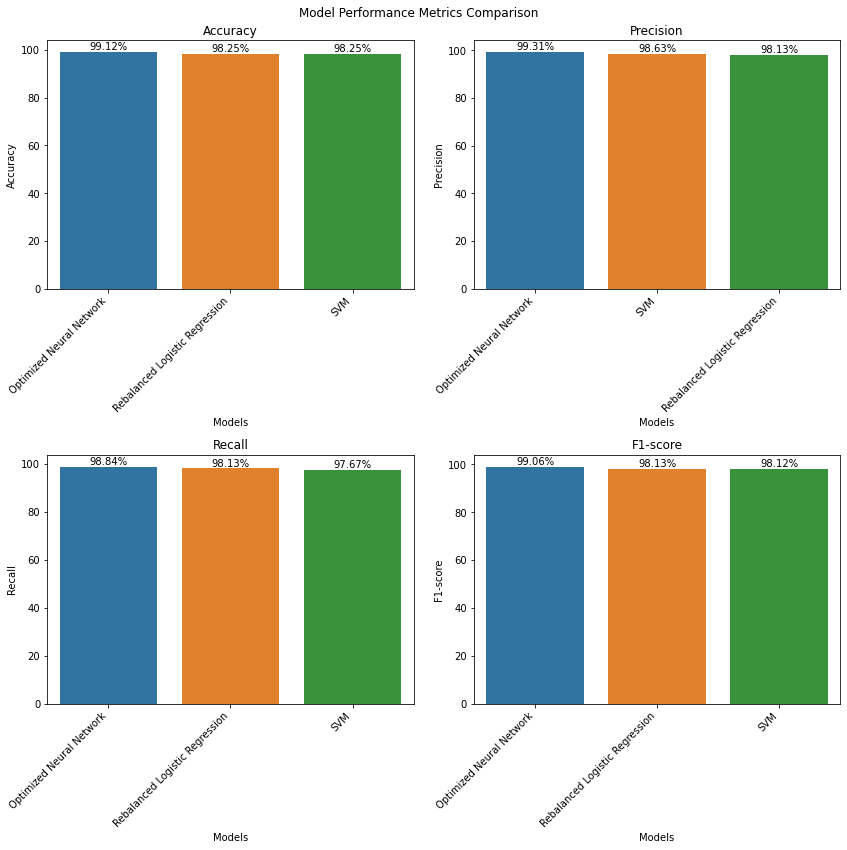

In [130]:
# Create a 2x2 plot to compare all the scores
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Model Performance Metrics Comparison')

# Plot Accuracy
accuracy_sorted = score_df.sort_values(by='Accuracy', ascending=False)
sns.barplot(ax=axes[0, 0], x='Models', y='Accuracy', data=accuracy_sorted)
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, horizontalalignment='right')
for i, v in enumerate(accuracy_sorted['Accuracy']):
    axes[0, 0].text(i, v, f"{v}%", ha='center', va='bottom', fontsize=10)

# Plot Precision
precision_sorted = score_df.sort_values(by='Precision', ascending=False)
sns.barplot(ax=axes[0, 1], x='Models', y='Precision', data=precision_sorted)
axes[0, 1].set_title('Precision')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, horizontalalignment='right')
for i, v in enumerate(precision_sorted['Precision']):
    axes[0, 1].text(i, v, f"{v}%", ha='center', va='bottom', fontsize=10)

# Plot Recall
recall_sorted = score_df.sort_values(by='Recall', ascending=False)
sns.barplot(ax=axes[1, 0], x='Models', y='Recall', data=recall_sorted)
axes[1, 0].set_title('Recall')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, horizontalalignment='right')
for i, v in enumerate(recall_sorted['Recall']):
    axes[1, 0].text(i, v, f"{v}%", ha='center', va='bottom', fontsize=10)

# Plot F1-score
f1_sorted = score_df.sort_values(by='F1-score', ascending=False)
sns.barplot(ax=axes[1, 1], x='Models', y='F1-score', data=f1_sorted)
axes[1, 1].set_title('F1-score')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, horizontalalignment='right')
for i, v in enumerate(f1_sorted['F1-score']):
    axes[1, 1].text(i, v, f"{v}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()